<a href="https://colab.research.google.com/github/GarethWilhelm/TS-Feature-Clustering/blob/Feature-clustering-ZAF/Final_Clustering_with_correct_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configs

## Required packages

In [137]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

try:
  !git clone https://github.com/wgova/automations
except:
  pass
else:
  os.chdir('automations')
  !git fetch origin && git pull
  os.chdir('../')

Mounted at /content/drive
fatal: destination path 'automations' already exists and is not an empty directory.
Already up to date.


In [138]:
# !pip install -q oec
# import oec
!pip install -U -q yellowbrick
import re
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools
import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,\
StandardScaler\
,normalize
from sklearn import decomposition
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import silhouette_samples,\
silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from automations.data_processors import *
from automations.correlation_analysis import *
from automations.feature_selection import *
from automations.clustering_helpers import *

## Load data

## Data processing

### Lists

In [139]:
# List of features
redundant_features = ['fft_coefficient','cwt_coefficients','count','change_quantiles','last_location_',
                      'index_mass_quantile','__attr_intercept','__attr_stderr',
                      'sum_values','sum_values','has_duplicate','length','quantile',
                      'ratio_beyond_r_sigma','ratio_value_number_to_time_series_length',
                      'agg','large_standard_deviation','number_crossing_m','number_cwt_peaks',
                      'reversal','value_count','spkt_welch_density','range_count','larger',
                      'variation_coefficient','max_langevin_fixed_point','reoccurring',
                      'symmetry_looking','variation','longest_strike_','energy_ratio_by_chunks',
                      'variance_larger_than_standard_deviation','__lag_0','fourier_entropy',
                      'friedrich_coefficients','bins_100','correlation', 'augmented','entropy','ar_coefficient']
min_feats = ['kurtosis','variance','mean','skewness','standard_deviation','median','sum_values',
             'maximum','length','minimum', 'lag', 'peaks', 'location', 'lempel', 'autolag', 'coefficients']
stats = ['kurtosis','^median$','linear_trend', 'standard_deviation', 'skewness', 'period']
stationarity = ['energy','komolgorov','sample']

### Data preparation

In [140]:
experiment = "stationary_entropy"
PATH = '/content/drive/My Drive/Stellenbosch/Gareth/sitc/year_origin_sitc_rev2.tsv'
all_eff_features = pd.read_csv(f'{PATH}/zaf_features_extracted.csv')\
 .rename(columns = {'Unnamed: 0': 'product_code'}, inplace = False)
all_eff_features.set_index('product_code',inplace=True)


In [141]:
features_filtered = change_column_prefix(
     remove_features_df(all_eff_features,filter_features(all_eff_features,redundant_features)))
features_filtered.columns

Index(['abs_energy', 'mean_abs_change', 'mean_change',
       'mean_second_derivative_central', 'median', 'mean',
       'standard_deviation', 'variance', 'skewness', 'kurtosis',
       'absolute_sum_of_changes', 'first_location_of_maximum',
       'first_location_of_minimum', 'maximum', 'minimum', 'c3__lag_1',
       'c3__lag_2', 'c3__lag_3', 'cid_ce__normalize_True',
       'cid_ce__normalize_False', 'number_peaks__n_1', 'number_peaks__n_3',
       'number_peaks__n_5', 'number_peaks__n_10', 'number_peaks__n_50',
       'linear_trend__attr_"pvalue"', 'linear_trend__attr_"rvalue"',
       'linear_trend__attr_"intercept"', 'linear_trend__attr_"slope"',
       'linear_trend__attr_"stderr"', 'lempel_ziv_complexity__bins_2',
       'lempel_ziv_complexity__bins_3', 'lempel_ziv_complexity__bins_5',
       'lempel_ziv_complexity__bins_10'],
      dtype='object')

# Run the ETL

In [142]:
features_filtered = change_column_prefix(
    remove_features_df(
        all_eff_features,filter_features(all_eff_features,redundant_features)))
# get exclude list for stationary features
# call stationary feature list on filtered feature dataframe
stationary_features_df = features_filtered[filter_features(features_filtered,stationarity)]
stationary_features_df.columns

Index(['abs_energy'], dtype='object')

In [143]:
# stationary_features_df = remove_outliers_iqr(stationary_features_df)
simplify_column_name(stationary_features_df,'autocorrelation__','auto_corr_')
simplify_column_name(stationary_features_df,'partial_autocorrelation__','pac_')
simplify_column_name(stationary_features_df,'augmented_dickey_fuller__attr_','adf_')
stationary_features_df.columns = (stationary_features_df.columns.str.strip().\
                                  str.replace('__tau_1','').\
                                  str.replace('coefficient__','').\
                                  str.replace('complexity__','').\
                                  str.replace('__k_10','').\
                                  str.replace('__max_bins_10','').\
                                  str.replace('__autolag','')
                                  )
simplify_column_name(stationary_features_df,'permutation_entropy__dimension','permutation_entropy')
clean_header(stationary_features_df)
# Drop correlated features (threshold: 0.5)
stationary_features_df = remove_features_df(stationary_features_df,drop_correlated_pairs(stationary_features_df,0.5))
stationary_features_df.columns

Index([], dtype='object')

In [144]:
stationary_features_df = remove_outliers_iqr(stationary_features_df)
stationary_features_df.reset_index() 

,product_code
0,zaf1110
1,zaf1121
2,zaf1122
3,zaf1123
4,zaf1124
...,...
674,zaf9310
675,zaf9410
676,zaf9510
677,zaf9610


In [145]:
# Add statistical features to dataframe
stats_features_df = features_filtered[filter_features(features_filtered,stats)]
stats_features_df = remove_outliers_iqr(stats_features_df)
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('__autolag_aic', ''))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('kurtosis', 'kurtosis'))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('median','median'))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('linear_trend__attr', 'trend'))
stats_features_df.reset_index() 

,product_code,kurtosis,median,"trend_""pvalue""","trend_""rvalue""","trend_""intercept""","trend_""slope""","trend_""stderr""",standard_deviation,skewness
0,zaf1110,1.545686,3.564000e+06,3.315796e-16,0.847602,-2.967426e+07,2.289611e+06,1.968909e+05,4.288151e+07,1.488710
1,zaf1121,-0.506985,1.456416e+07,4.056517e-14,0.809942,-1.936363e+08,1.490191e+07,1.468473e+06,2.973828e+08,1.086157
2,zaf1122,2.235449,9.031385e+05,1.904704e-08,0.729790,-1.972867e+07,1.687599e+06,2.439459e+05,2.936439e+07,1.864961
3,zaf1123,-0.325437,2.504446e+06,4.494836e-12,0.777921,-1.272169e+07,1.193398e+06,1.336773e+05,2.390992e+07,1.011084
4,zaf1124,2.275437,3.961318e+06,3.336319e-12,0.771790,-3.528286e+07,2.462820e+06,2.761275e+05,5.157764e+07,1.833505
...,...,...,...,...,...,...,...,...,...,...
674,zaf9310,15.983471,1.543661e+08,2.051275e-03,0.403384,-5.913921e+08,6.175184e+07,1.906206e+07,2.474339e+09,3.832982
675,zaf9410,2.420401,2.162300e+06,1.586659e-13,0.798972,-3.428896e+06,3.220274e+05,3.298409e+04,6.514623e+06,1.685828
676,zaf9510,7.587690,3.965538e+06,1.686853e-08,0.674095,-3.637840e+07,2.652538e+06,3.992434e+05,6.246555e+07,2.659331
677,zaf9610,8.611174,4.371730e+05,2.961316e-01,0.149174,1.920348e+06,8.353065e+04,7.909844e+04,8.242306e+06,2.903055


In [146]:
# Merge stationarity and statistical features
features_uncorrelated = pd.merge(stationary_features_df,stats_features_df,on='product_code')
clean_header(features_uncorrelated)

,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness
product_code,,,,,,,,,
zaf1110,1.545686,3.564000e+06,3.315796e-16,0.847602,-2.967426e+07,2.289611e+06,1.968909e+05,4.288151e+07,1.488710
zaf1121,-0.506985,1.456416e+07,4.056517e-14,0.809942,-1.936363e+08,1.490191e+07,1.468473e+06,2.973828e+08,1.086157
zaf1122,2.235449,9.031385e+05,1.904704e-08,0.729790,-1.972867e+07,1.687599e+06,2.439459e+05,2.936439e+07,1.864961
zaf1123,-0.325437,2.504446e+06,4.494836e-12,0.777921,-1.272169e+07,1.193398e+06,1.336773e+05,2.390992e+07,1.011084
zaf1124,2.275437,3.961318e+06,3.336319e-12,0.771790,-3.528286e+07,2.462820e+06,2.761275e+05,5.157764e+07,1.833505
...,...,...,...,...,...,...,...,...,...
zaf9310,15.983471,1.543661e+08,2.051275e-03,0.403384,-5.913921e+08,6.175184e+07,1.906206e+07,2.474339e+09,3.832982
zaf9410,2.420401,2.162300e+06,1.586659e-13,0.798972,-3.428896e+06,3.220274e+05,3.298409e+04,6.514623e+06,1.685828
zaf9510,7.587690,3.965538e+06,1.686853e-08,0.674095,-3.637840e+07,2.652538e+06,3.992434e+05,6.246555e+07,2.659331


In [147]:
features_uncorrelated.fillna(0,inplace=True)
features_uncorrelated.isnull().sum()

kurtosis              0
median                0
trend_pvalue          0
trend_rvalue          0
trend_intercept       0
trend_slope           0
trend_stderr          0
standard_deviation    0
skewness              0
dtype: int64

## EDA and correlation analysis

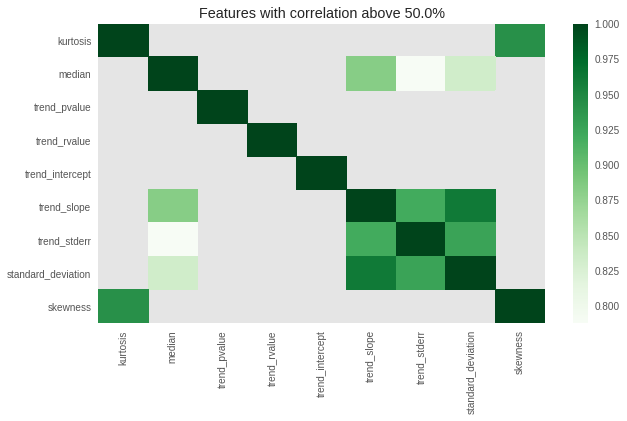

In [148]:
image_dump = f"{PATH}/images"
# Check if all features are not correlated
plot_correlated_features(features_uncorrelated,0.5)
plt.savefig(f"{image_dump}/_correlation_{experiment}")
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series

# Clustering

## PCA + k-Means

* Scale features using Standard Scaler
* Dimension reduction to 2 PCs
* Locate optimum number of cluster

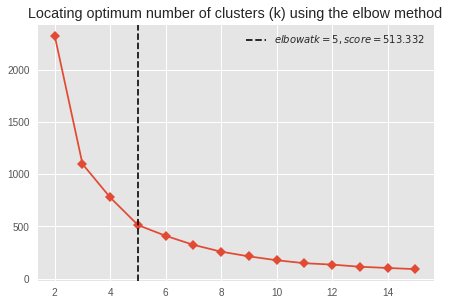

In [149]:
features_uncorrelated = scale_features(features_uncorrelated)
X_scaled_transposed = np.asarray(features_uncorrelated)
product_name = 'all_products'
# Reduce dimensions using PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_uncorrelated)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
# Plot the explained variances
features = range(pca.n_components_)

# Optimum clusters
# plot_elbow_silhoutte_k_evaluation(f"{product_name}_{experiment}_pca_kmeans",np.asarray(PCA_components),15)
kelbow_visualizer = KElbowVisualizer(
    KMeans(random_state=42), k=15,metric='distortion',
    timings=False,locate_elbow=True,size=(512, 340))
kelbow_visualizer.fit(np.asarray(PCA_components))
pca_k_value = kelbow_visualizer.elbow_value_
plt.title('Locating optimum number of clusters (k) using the elbow method')
plt.legend()
plt.savefig(f"{image_dump}/{experiment}_elbow")

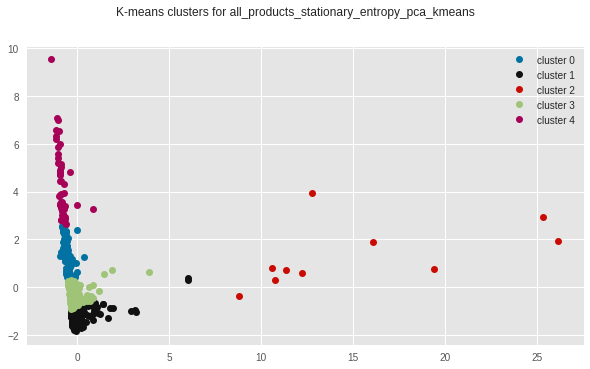

In [150]:
clusters_features_uncorrelated = plot_kmeans_clusters(np.asarray(PCA_components),pca_k_value,f"{product_name}_{experiment}_pca_kmeans",
                                                      f"{image_dump}")



In [151]:
#features_uncorrelated['product_code'].astype(str)
features_uncorrelated.index

Index(['zaf1110', 'zaf1121', 'zaf1122', 'zaf1123', 'zaf1124', 'zaf1211',
       'zaf1212', 'zaf1213', 'zaf1221', 'zaf1222',
       ...
       'zaf8994', 'zaf8996', 'zaf8997', 'zaf8998', 'zaf8999', 'zaf9310',
       'zaf9410', 'zaf9510', 'zaf9610', 'zaf9710'],
      dtype='object', name='product_code', length=679)

In [152]:
details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,clusters_features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'product_code':'names'})
get_names.names.astype('str')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
country_cluster.head()

,names,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness,cluster
0,zaf1110,-0.300170,-0.158196,-0.31093,0.744495,-0.079990,-0.048748,-0.106759,-0.048799,-0.138332,3
1,zaf1121,-0.600818,-0.074545,-0.31093,0.621667,-1.489870,0.855027,0.524674,0.948432,-0.506231,1
2,zaf1122,-0.199142,-0.178430,-0.31093,0.360250,0.005530,-0.091887,-0.083393,-0.101764,0.205528,3
3,zaf1123,-0.574228,-0.166253,-0.31093,0.517230,0.065782,-0.127301,-0.138149,-0.123137,-0.574841,1
4,zaf1124,-0.193286,-0.155174,-0.31093,0.497233,-0.128217,-0.036336,-0.067413,-0.014725,0.176781,3


In [153]:
groups = country_cluster.groupby(['cluster']).agg('mean')


In [154]:
#clust = groups.reset_index()
dict_clust = {0:'cluster_0',
              1: 'cluster_1',
              2: 'cluster_2',
              3: 'cluster_3',
              4: 'cluster_4',
              5: 'cluster_5'
              }
clust = groups.reset_index()
clust.replace({'cluster': dict_clust},inplace=True)
clust.set_index('cluster',inplace=True)
# x = clust.iloc[-1,:]
clust

,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness
cluster,,,,,,,,,
cluster_0,0.485238,-0.126191,0.339485,-1.141870,0.234522,-0.198447,-0.142279,-0.168207,0.646706
cluster_1,-0.569212,-0.028910,-0.309471,0.639646,0.010833,-0.028932,-0.069266,-0.058288,-0.753848
cluster_2,-0.094561,6.084236,-0.309659,0.401419,-6.490538,7.378874,7.074139,7.356347,0.027516
cluster_3,-0.200218,-0.119994,-0.282540,0.238885,0.095186,-0.130902,-0.121032,-0.125052,-0.048560
cluster_4,2.551380,-0.164127,2.094647,-1.671828,0.203841,-0.196925,-0.122379,-0.150431,2.311278


In [155]:
b = clust.T

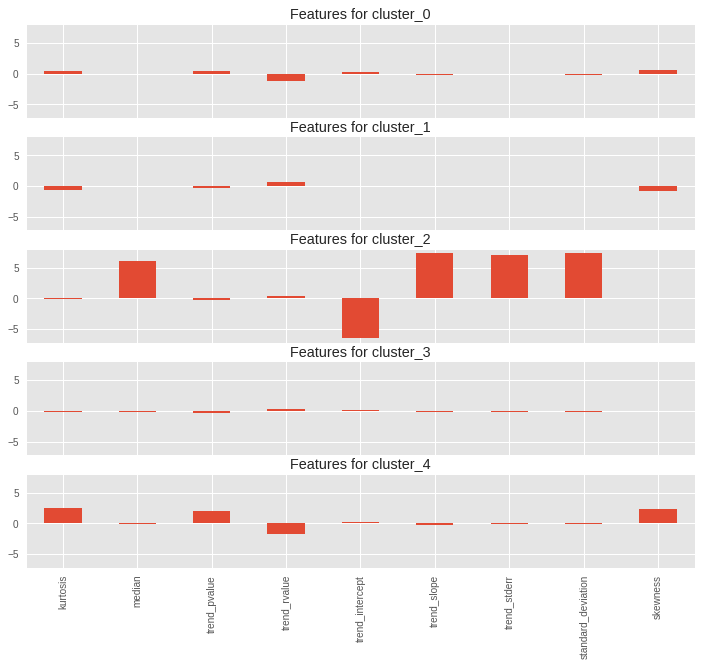

In [156]:
n = len(b.columns)
fig, ax = plt.subplots(n, 1, figsize=(12, n * 2), sharex=True,sharey=True)
for i in range(n):
    plt.sca(ax[i])
    col = b.columns[i]
    b[col].plot(kind='bar')
    plt.title(f"Features for {col}")
    # plt.tight_layout()
fig.savefig(f"{image_dump}/{product_name}_{experiment}_pca_kmeans_features.png",bbox_inches = "tight")

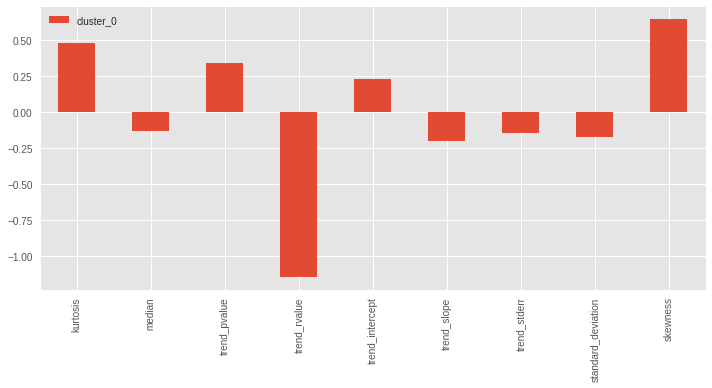

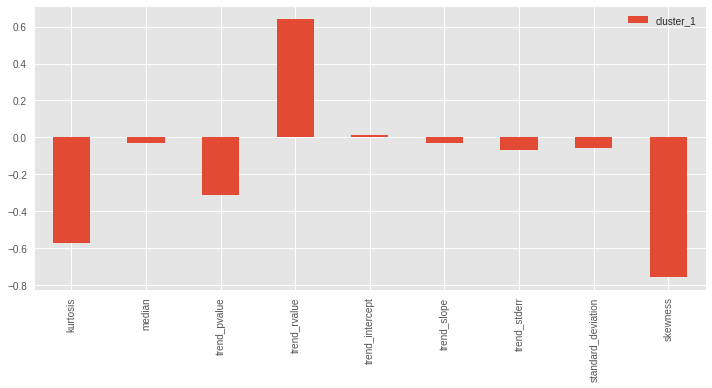

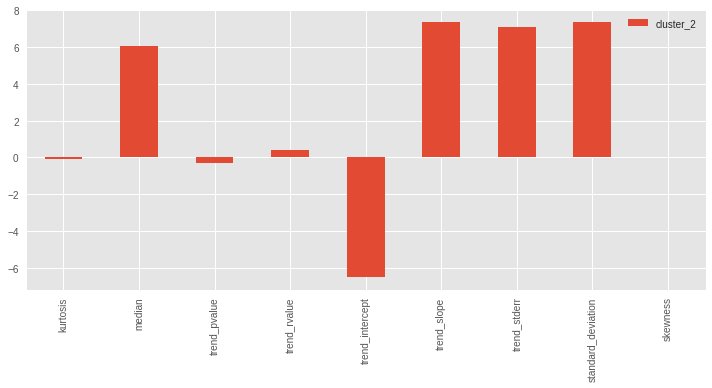

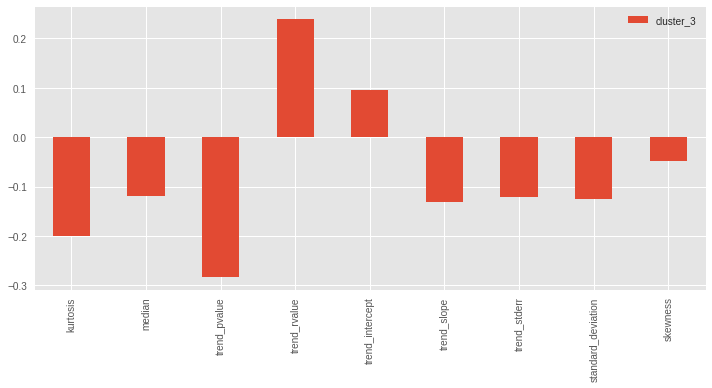

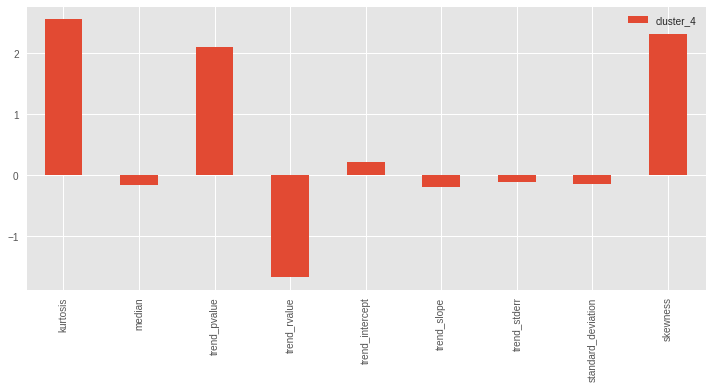

In [157]:
# AR0-1-2-3, autoregressive coeff. Tells you whethere the ts fits an autoregressive model.
# AR1 shows fits auto reg model of order 1 etc...
# aug dicky fuller, tells whether or not ts has a unit root - tells whether ts is stationary- stationary means behaviour doesnt change, almost determines predictability or not
# kurtosis - sensitivity to outlier
# permu entropy - exclude - entropy used in place of shannon entropy
for col in b.columns:
  b[col].plot(kind='bar',figsize=(10,5.5))
  plt.legend()
  plt.tight_layout()
  plt.savefig(f"{image_dump}/{col}_{product_name}_features.png",bbox_inches = "tight")
  plt.show()

# Cluster analysis

In [158]:
trade_dframe = pd.read_excel(f'{PATH}/zaf_df.xlsx', usecols=['year', 'export_val', 'zaf_code'])
trade_dframe.head()


,year,export_val,zaf_code
0,1962,42000.0,zaf6289
1,1962,2000.0,zaf6352
2,1962,8000.0,zaf6577
3,1962,290000.0,zaf6731
4,1962,6000.0,zaf6760


In [159]:
country_cluster.head()

,names,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness,cluster
0,zaf1110,-0.300170,-0.158196,-0.31093,0.744495,-0.079990,-0.048748,-0.106759,-0.048799,-0.138332,3
1,zaf1121,-0.600818,-0.074545,-0.31093,0.621667,-1.489870,0.855027,0.524674,0.948432,-0.506231,1
2,zaf1122,-0.199142,-0.178430,-0.31093,0.360250,0.005530,-0.091887,-0.083393,-0.101764,0.205528,3
3,zaf1123,-0.574228,-0.166253,-0.31093,0.517230,0.065782,-0.127301,-0.138149,-0.123137,-0.574841,1
4,zaf1124,-0.193286,-0.155174,-0.31093,0.497233,-0.128217,-0.036336,-0.067413,-0.014725,0.176781,3


<Figure size 720x396 with 0 Axes>

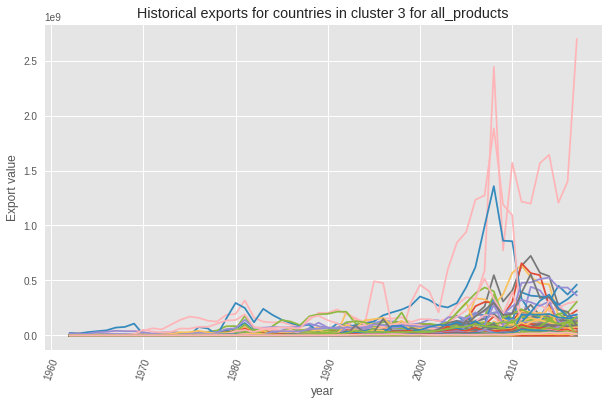

<Figure size 720x396 with 0 Axes>

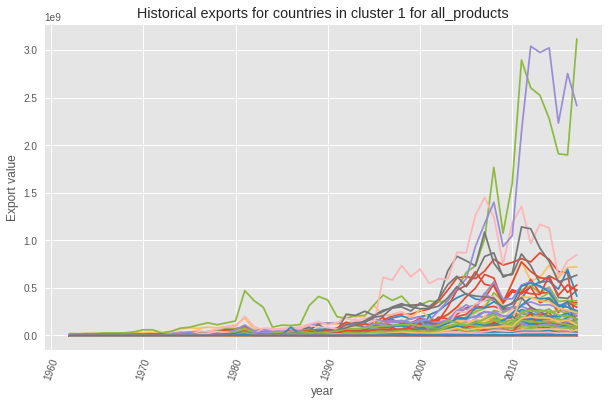

<Figure size 720x396 with 0 Axes>

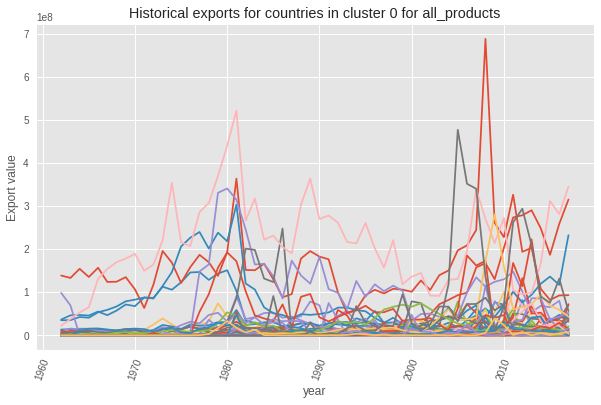

<Figure size 720x396 with 0 Axes>

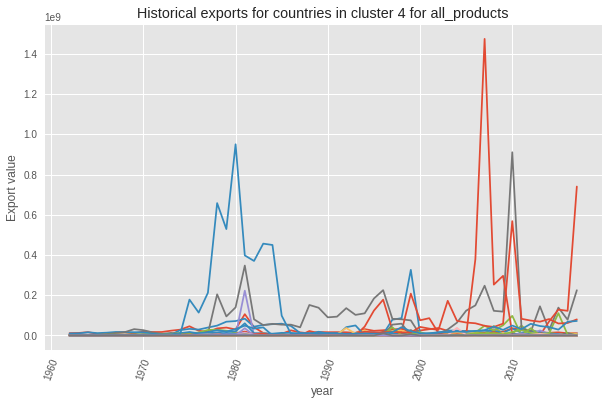

<Figure size 720x396 with 0 Axes>

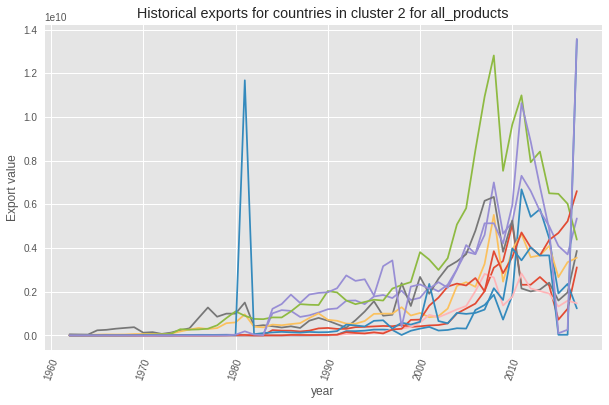

In [160]:
# Plots for country comparison per product 
for c in country_cluster.cluster.unique():
  cluster = country_cluster[country_cluster.cluster==c]
  country_list = cluster['names'].unique()
  product = pd.pivot_table(trade_dframe,index='year',columns='zaf_code',
                           values='export_val',aggfunc=np.mean)
  df = product[country_list]
  df.fillna(0,inplace=True)
  plt.figure(figsize=(10,5.5))
  df.plot(subplots=False,figsize=(10,6),legend=False,
                            title=(f"Historical exports for countries in cluster {c} for {product_name}"))
  plt.xticks(rotation=70)
  # plt.legend()
  plt.ylabel("Export value")
  plt.savefig(f"{image_dump}/{product_name}_cluster_{c}")
  plt.show()